In [2]:
import sys
import numpy as np
import os
import pandas as pd
import pickle
sys.path.append('/home/ak/Documents/Research/hsmm/')
_features_path= '/home/ak/Documents/Data/features_test/' #directory to save data
_path=os.getenv('FINANCE_DATA')
import matplotlib.pyplot as plt

In [2]:
os.listdir(_path)
#_path

['EEM', 'HSBA', 'JPM.N', 'GOOG', 'SYNT', 'mySYNT']

In [3]:
from hsmm_core.observation_models import *
from hsmm_core.hmm import *
from hsmm_core.hmm_utils import load_data
from hsmm_core.prediction_engines import *

In [4]:
##useful functions##
def listdirs(folder): #return only directories from a master folder
    return [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]

_no=8
ticker = symbols[_no]

data_path=os.path.join(_features_path_path+ticker)
#listdirs(data_path)
ticker

In [9]:
no_days=len(os.listdir(os.path.join(_path+ticker)))
_dates=os.listdir(os.path.join(_path+ticker))

In [27]:
no_days

5

In [10]:
os.path.join(_path+ticker)

'/home/ak/Data/FinData/JPM.N'

In [11]:
n_hidden_states = 2
ticker='JPM.N'

zero_pc_threshold = 1e-5
init_params = {
    "obs_model_params": {
                                'epsilon': zero_pc_threshold,
                                'obs_model_name': 'ExpUniGauss',
                                'init_params': {'epsilon': zero_pc_threshold},
                                'em_init_method': initialization_method.cluster

    },
    "hidden_model_params": {
                                'no_hidden_states': n_hidden_states,
                                # 'pi':startprob,
                                # 'tpm': transmat
                                'em_init_method': initialization_method.uniform
    },
    "update_tag": 'tpsml'
}



In [12]:
type(init_params)
_params=init_params.keys()
init_params[_params[0]].keys()
init_params["hidden_model_params"]["no_hidden_states"]

2

In [1]:
data_dic, data_sampling_tag = load_data(ticker, resample=None,
                                        no_of_days=no_days,
                                       # file_name=['20090106.csv'],
                                       load_columns=['TradedTime', 'Duration','TradedPrice', 'ReturnTradedPrice'],
                                        only_mkt_hours=True)


NameError: name 'load_data' is not defined

In [14]:
labelling_methods = [
    {'method': dl_choices.control_chart,
  'cc_quantiles': [40, 70],
      'rolling_window': 15,
    },
    # {
    #     'method': dl_choices.control_chart,
    #     'cc_quantiles': [20, 80],
    #     'rolling_window': 10,
    # },
#     {
#         'method': dl_choices.simple_all,
#         'rolling_window': 5,
#     },
#     {
#         'method': dl_choices.simple_ma,
#         'rolling_window': 5,
#     },
    {
        'method': dl_choices.simple_ep,
        'rolling_window': 20,
        'cmp_threshold': 0.05, # Use this value to set a threshold in comparison, i.e. it does not suffice 
                            # to have P_t < P_{t + window} but  P_t < ( 1- cmp_threshold) * P_{t + window} 
    },
    {
        'method': dl_choices.simple_ep,
        'rolling_window': 20,
    },
]

labellers_ = []

for labelling_method in labelling_methods:
    method = labelling_method['method']

    if method is dl_choices.control_chart:
        # look for qunatile values, if not use default 10/90
        labellers_.append(data_labelling_cc(**labelling_method))
    else:
        labellers_.append(data_labelling_simple(**labelling_method))

In [15]:

hmm_calibration_engine = hmm_calibration(no_parallel_procs=None,
                                         init_params=init_params)

trained_hmms = hmm_calibration_engine.hmm_fit_func(ticker, data_dic, 'resample__', force_recalc=True)

print trained_hmms

# a_model = trained_hmms['20140122']
# a_model.map_metrics(data_dic['20140122'])
#



Calibrating hmm on date 20090106
Number of points in data set is 7789, number of points with large price change 2533
Calibrating hmm on date 20090105
Number of points in data set is 7834, number of points with large price change 2478
Calibrating hmm on date 20090102
Number of points in data set is 5123, number of points with large price change 2033
Calibrating hmm on date 20090108
Number of points in data set is 6835, number of points with large price change 2185
Calibrating hmm on date 20090109
Number of points in data set is 7165, number of points with large price change 2005
{'20090106': <hsmm_core.hmm.hmm_engine object at 0x7f12999ca0d0>, '20090105': <hsmm_core.hmm.hmm_engine object at 0x7f12999ca5d0>, '20090102': <hsmm_core.hmm.hmm_engine object at 0x7f12999ca350>, '20090108': <hsmm_core.hmm.hmm_engine object at 0x7f12999ca490>, '20090109': <hsmm_core.hmm.hmm_engine object at 0x7f12999ca890>}


In [24]:
prediction_params = {
    'labelling_methods':  labelling_methods,
    'feature_generation': feature_generation.one_model_to_one_fset,
}

prediction_eng = hs_prediction_engine(hmm_init_params=init_params,
                                      prediction_innit_params=prediction_params,
                                      no_parallel_procs=None)

In [25]:
features, _ = prediction_eng.train_model_data(ticker, data_dic, 'resample__', force_hmm_recalc=False)

In [58]:
M=5
T=len(_dates)

_ll_results= {'_likeli_': {_no: {} for _no in xrange(2, 6)}}

for i in xrange(0,T):
    print _dates[i]

20090105.csv
20090102.csv
20090106.csv
20090108.csv
20090109.csv


In [59]:
for idx, _no in enumerate(xrange(2,6)):
    print _no
    init_params["hidden_model_params"]["no_hidden_states"] =_no
    hmm_calibration_engine = hmm_calibration(no_parallel_procs=None,
                                             init_params=init_params)
    trained_hmms = hmm_calibration_engine.hmm_fit_func(ticker, data_dic, 
                                                       'resample__', force_recalc=True)
    for _date in range(0,T):
        print _dates[_date]
        filename, _ = os.path.splitext(_dates[_date])
        _no_items=len(trained_hmms[filename].__dict__['history_likelihood_'])
        _likel_=trained_hmms[filename].__dict__['history_likelihood_'][_no_items-1]
        print _likel_
        _ll_results['_likeli_'][_no][_date] =_likel_


2
Calibrating hmm on date 20090106
Number of points in data set is 7789, number of points with large price change 2533
Calibrating hmm on date 20090105
Number of points in data set is 7834, number of points with large price change 2478
Calibrating hmm on date 20090102
Number of points in data set is 5123, number of points with large price change 2033
Calibrating hmm on date 20090108
Number of points in data set is 6835, number of points with large price change 2185
Calibrating hmm on date 20090109
Number of points in data set is 7165, number of points with large price change 2005
20090105.csv
14308.5433344
20090102.csv
3921.86364641
20090106.csv
11355.7703267
20090108.csv
8830.44295743
20090109.csv
11603.4541093
3
Calibrating hmm on date 20090106
Number of points in data set is 7789, number of points with large price change 2533
Calibrating hmm on date 20090105
Number of points in data set is 7834, number of points with large price change 2478
Calibrating hmm on date 20090102
Number of

In [46]:
for _date in range(0,T):
    filename, _ = os.path.splitext(_dates[_date])
    _no_items=len(trained_hmms[filename].__dict__['history_likelihood_'])
    _likel_=trained_hmms[filename].__dict__['history_likelihood_'][_no_items-1]
    print _likel_

14308.5433344
3921.86364641
11355.7703267
8830.44295743
11603.4541093


In [25]:
for i in xrange(2,6):
    print i

2
3
4
5


In [85]:
_ll_results['_likeli_'][3]

{0: 14553.238542445497,
 1: 4135.0115405634615,
 2: 12094.172781635829,
 3: 9249.7113230805389,
 4: 12154.270515995562}

In [86]:
_ll_results['_likeli_'][5]

{0: 14658.011670987871,
 1: 4106.0538638326334,
 2: 12117.978386140743,
 3: 9342.9139162024676,
 4: 12078.895530790629}

In [77]:
_ll_results['_likeli_'][4]

{0: 14690.649402877452,
 1: 4167.9202045505981,
 2: 12153.259442271943,
 3: 9419.3575751274948,
 4: 12198.41692689101}

In [82]:
_no_states=_ll_results['_likeli_'].keys()

In [99]:
dictionary = _ll_results['_likeli_']
print(dictionary.keys())

[2, 3, 4, 5]


In [103]:
print(dictionary[2])

{0: 14308.54333435061, 1: 3921.8636464133974, 2: 11355.770326676797, 3: 8830.4429574270343, 4: 11603.454109344731}


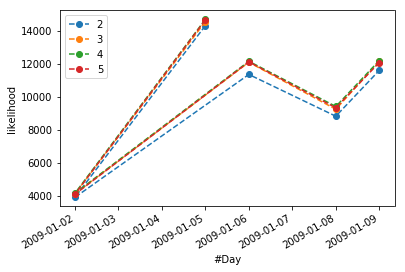

In [138]:
fig, ax = plt.subplots()
fig.autofmt_xdate()
for k in dictionary:
    xs, ys = zip(*sorted(dictionary[k].items(), key=lambda x: x[0]))
    ax.plot([datetime.strptime(_dates[i].split('.')[0], '%Y%m%d') for i in xs],
            ys,marker='o', linestyle='--', label=k)
ax.legend()
plt.xlabel('#Day')
plt.ylabel('likelihood')
plt.show()

In [115]:
for _date in range(0,4):
    filename, _ = os.path.splitext(_dates[_date])
    print filename

20090105
20090102
20090106
20090108


In [118]:
k

5